# Modelling event times on the Santander Cycles data using graph-based mutually exciting processes (GB-MEP)
First, import the library `gb_mep`:

In [20]:
## Import library gb_mep
import gb_mep

Next, import the Santander Cycles data from the directory `data` (after running the scripts for data preprocessing, as detailed in the main `README` file for the library `gb_mep`).

In [21]:
## Load all required files after importing relevant libraries
import pickle
import numpy as np
import pandas as pd
santander_train = pd.read_csv('../data/santander_train.csv') 
santander_test = pd.read_csv('../data/santander_test.csv') 
santander_distances = np.load('../data/santander_distances.npy')
with open('../data/santander_dictionary.pkl', 'rb') as f:
    santander_dictionary = pickle.load(f)

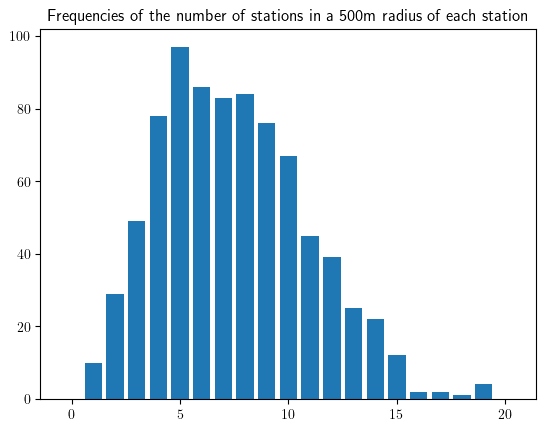

In [22]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Lato']})
rc('text', usetex=True)
plt.bar(range(21),[list(np.sum(santander_distances < .5, axis=1)).count(x) for x in range(21)])
plt.title('Frequencies of the number of stations in a 500m radius of each station')
plt.show()

Inspect the Santander Cycles data:

In [23]:
santander_train

,start_id,end_id,start_time,end_time
0,722,131,0.483492,13.192747
1,531,460,0.484768,23.477447
2,515,603,0.624303,4.196019
3,804,689,0.807900,13.604670
4,740,48,1.568787,31.912915
...,...,...,...,...
6453258,302,637,241912.321072,241919.498489
6453259,740,342,241912.686823,241919.489431
6453260,327,324,241913.941339,241917.596443
6453261,224,337,241913.962367,241919.498538


Define a `gb_mep` object `G` using the DataFrame `santander_train`, mapping of station names to labels given by `santander_dictionary`, and matrix of node distances `santander_distances`, and define two dictionaries `start_times` and `end_times` from `G` via the function `augment_start_times`, with input `santander_test`:

In [24]:
G = gb_mep.gb_mep(df=santander_train, id_map=santander_dictionary, distance_matrix=santander_distances)
start_times, end_times = G.augment_start_times(santander_test)

Fit a Poisson process to the training data used to construct `G`:

In [ ]:
res_pp = G.fit_poisson()

Fit a mutually exciting process to the training data used to construct `G`, which models to the start times only as a function of the end times at the same station:

In [ ]:
res_mep = G.fit(x0=-4*np.ones(3), subset_nodes=range(10), start_times=False, end_times=True, distance_start=False, distance_end=False)

Fit a self-exciting process to the training data used to construct `G`, which models to the start times only as a function of the start times at the same station:

In [ ]:
res_sep = G.fit(x0=-4*np.ones(3), subset_nodes=range(10), start_times=True, end_times=False, distance_start=False, distance_end=False)

Fit a self-and-mutually exciting process to the training data used to construct `G`, which models to the start times only as a function of the event times occurred at the same station:

In [ ]:
start_vals = gb_mep.combine_dictionaries(d1=res_sep, d2=res_mep, cut_d2=1, add_in_between=None)
res_smep = G.fit(x0=start_vals, subset_nodes=range(10), start_times=True, end_times=True, distance_start=False, distance_end=False)

In [ ]:
start_vals = gb_mep.append_to_dictionary(d=res_sep, val=np.log(1))
res_gbmep_start = G.fit(x0=start_vals, subset_nodes=range(10), start_times=True, end_times=False, distance_start=True, distance_end=False, thresh=.5, min_nodes=3)

In [ ]:
start_vals = gb_mep.insert_in_dictionary(d=res_smep, val=np.log(1), pos=3)
res_gbmep = G.fit(x0=start_vals, subset_nodes=range(10), start_times=True, end_times=True, distance_start=True, distance_end=False, thresh=.5, min_nodes=3)

Calculate the $p$-values for all processes, for the node with index `4`:

In [ ]:
index = 4
# p-values for Poisson process
p_poisson_train, p_poisson_test = G.pvals_poisson_process(param=res_pp[index], node_index=index, start_times=start_times, test_split=True)
# p-values for MEP
pp = gb_mep.transform_parameters(res_mep[index].x)
p_mep_train, p_mep_test = G.pvals_mep(params=pp, node_index=index, start_times=start_times, end_times=end_times, test_split=True)
# p-values for SEP
pp = gb_mep.transform_parameters(res_sep[index].x)
p_sep_train, p_sep_test = G.pvals_sep(params=pp, node_index=index, start_times=start_times, test_split=True)
# p-values for SMEP
pp = gb_mep.transform_parameters(res_smep[index].x)
p_smep_train, p_smep_test = G.pvals_smep(params=pp, node_index=index, start_times=start_times, end_times=end_times, test_split=True)
# p-values for GB-MEP with start times only
pp  = gb_mep.transform_parameters(res_gbmep_start[index].x)
p_gbmep_start_train, p_gbmep_start_test = G.pvals_gbmep_start(params=pp, node_index=index, subset_nodes=res_gbmep_start[index].subset_nodes, start_times=start_times, test_split=True)
# p-values for GB-MEP
pp = gb_mep.transform_parameters(res_gbmep[index].x)
p_gbmep_train, p_gbmep_test = G.pvals_gbmep_start_self(params=pp, node_index=index, subset_nodes=res_gbmep[index].subset_nodes, start_times=start_times, end_times=end_times, test_split=True)

Calculate the observed quantiles for all distributions of $p$-values in the test set:

In [ ]:
x = np.linspace(start=0, stop=1, num=501, endpoint=False)[1:]
y_poisson = np.percentile(a=p_poisson_test, q=x*100)
y_mep = np.percentile(a=p_mep_test, q=x*100)
y_sep = np.percentile(a=p_sep_test, q=x*100)
y_smep = np.percentile(a=p_smep_test, q=x*100)
y_gbmep_start = np.percentile(a=p_gbmep_start_test, q=x*100)
y_gbmep = np.percentile(a=p_gbmep_test, q=x*100)

Plot observed quantiles against the theoretical quantiles under the null hypothesis of correct model specification:

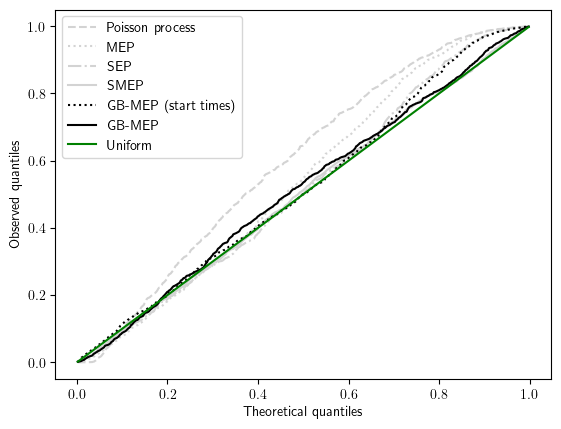

In [ ]:
plt.plot(x, y_poisson, label='Poisson process', ls='dashed', c='lightgray')
plt.plot(x, y_mep, label='MEP', ls='dotted', c='lightgray')
plt.plot(x, y_sep, label='SEP', ls='dashdot', c='lightgray')
plt.plot(x, y_smep, label='SMEP', c='lightgray')
plt.plot(x, y_gbmep_start, label='GB-MEP (start times)', ls='dotted', c='black')
plt.plot(x, y_gbmep, label='GB-MEP', c='black')
plt.plot(x, x, label='Uniform', c='green')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Observed quantiles')
plt.legend()
plt.show()

Perform Kolmogorov-Smirnov tests:

In [ ]:
import scipy.stats as stats
k_poisson = stats.kstest(p_poisson_train, stats.uniform.cdf).statistic
k_mep = stats.kstest(p_mep_train, stats.uniform.cdf).statistic
k_sep = stats.kstest(p_sep_train, stats.uniform.cdf).statistic
k_smep = stats.kstest(p_smep_train, stats.uniform.cdf).statistic
k_gbmep_start = stats.kstest(p_gbmep_start_train, stats.uniform.cdf).statistic
k_gbmep = stats.kstest(p_gbmep_train, stats.uniform.cdf).statistic

Display results:

In [ ]:
k_poisson, k_mep, k_sep, k_smep, k_gbmep_start, k_gbmep

(0.16452359884688228,
 0.12402656766661369,
 0.08501160890943371,
 0.06313062327536728,
 0.07647647715926564,
 0.05881947863390519)

In [ ]:
import scipy.stats as stats
k_poisson = stats.kstest(p_poisson_test, stats.uniform.cdf).statistic
k_mep = stats.kstest(p_mep_test, stats.uniform.cdf).statistic
k_sep = stats.kstest(p_sep_test, stats.uniform.cdf).statistic
k_smep = stats.kstest(p_smep_test, stats.uniform.cdf).statistic
k_gbmep_start = stats.kstest(p_gbmep_start_test, stats.uniform.cdf).statistic
k_gbmep = stats.kstest(p_gbmep_test, stats.uniform.cdf).statistic
k_poisson, k_mep, k_sep, k_smep, k_gbmep_start, k_gbmep

(0.1612598555675867,
 0.1284562587728968,
 0.08295612691341658,
 0.025995477648352416,
 0.07809134450661481,
 0.03843952330158362)

In [ ]:
stats.cramervonmises(rvs=p_smep_train, cdf=stats.uniform.cdf).statistic, stats.cramervonmises(rvs=p_gbmep_train, cdf=stats.uniform.cdf).statistic

(5.830055949428466, 5.2557624704305175)

In [ ]:
stats.cramervonmises(rvs=p_smep_test, cdf=stats.uniform.cdf).statistic, stats.cramervonmises(rvs=p_gbmep_test, cdf=stats.uniform.cdf).statistic

(0.1505111420821012, 0.5913680618946713)